In [37]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: F:\ID2223\Air_Quality_Prediction
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features  
2. Add lag features and create a new Feature Group    
3. Create training data using the feature view
4. Train baseline model (only weather features) and enhanced model (weather+lagged features)
5. Evaluate model performance
6. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [38]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [39]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-14 02:32:24,798 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-14 02:32:24,804 INFO: Initializing external client
2025-11-14 02:32:24,806 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-14 02:32:26,068 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1298582


In [40]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> Add Lagged Features  </span>

Lag features can capture patterns in time series. We will add PM2.5 values from 1, 2, and 3 days ago as new features.


In [41]:
# Read air quality data from Feature Group
print("📊 Reading Air Quality data from Feature Group...")
air_quality_df = air_quality_fg.read()
print(f"Original rows: {len(air_quality_df)}")
print(f"Date range: {air_quality_df['date'].min()} to {air_quality_df['date'].max()}")
print(f"\nOriginal columns: {air_quality_df.columns.tolist()}")


📊 Reading Air Quality data from Feature Group...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 
Original rows: 2776
Date range: 2017-10-04 00:00:00+00:00 to 2025-11-13 00:00:00+00:00

Original columns: ['date', 'pm25', 'country', 'city', 'street', 'url']


In [42]:
# Add lag features
print("\n🔄 Adding lag features (PM2.5 from 1, 2, 3 days ago)...")
air_quality_with_lags = util.add_lagged_features(
    air_quality_df,
    target_column='pm25',
    lags=[1, 2, 3]
)

print("\n✅ Lag features created successfully!")
print(f"New columns: {[col for col in air_quality_with_lags.columns if 'lag_' in col]}")
print(f"Rows after removing NaN: {len(air_quality_with_lags)}")

display(air_quality_with_lags[['date', 'city', 'pm25', 'lag_1_pm25', 'lag_2_pm25', 'lag_3_pm25']].head(10))


🔄 Adding lag features (PM2.5 from 1, 2, 3 days ago)...
Created feature: lag_1_pm25
Created feature: lag_2_pm25
Created feature: lag_3_pm25

Lagged features summary:
  - Initial rows: 2776
  - Rows after dropping NaN: 2773
  - Dropped rows: 3

✅ Lag features created successfully!
New columns: ['lag_1_pm25', 'lag_2_pm25', 'lag_3_pm25']
Rows after removing NaN: 2773


,date,city,pm25,lag_1_pm25,lag_2_pm25,lag_3_pm25
3,2017-10-07 00:00:00+00:00,Stockholm,13.0,8.0,9.0,13.0
4,2017-10-08 00:00:00+00:00,Stockholm,8.0,13.0,8.0,9.0
5,2017-10-09 00:00:00+00:00,Stockholm,7.0,8.0,13.0,8.0
6,2017-10-10 00:00:00+00:00,Stockholm,12.0,7.0,8.0,13.0
7,2017-10-11 00:00:00+00:00,Stockholm,12.0,12.0,7.0,8.0
8,2017-10-12 00:00:00+00:00,Stockholm,10.0,12.0,12.0,7.0
9,2017-10-13 00:00:00+00:00,Stockholm,9.0,10.0,12.0,12.0
10,2017-10-14 00:00:00+00:00,Stockholm,11.0,9.0,10.0,12.0
11,2017-10-15 00:00:00+00:00,Stockholm,21.0,11.0,9.0,10.0
12,2017-10-16 00:00:00+00:00,Stockholm,28.0,21.0,11.0,9.0


### Save data with lagged features to Feature Group

We create a new Feature Group 'air_quality-with_1ags' to store data containing lagged features, which can be reused in future training and inference.


In [43]:
# Create or get Feature Group with lagged features
print("💾 Creating/retrieving Feature Group 'air_quality_with_lags'...")

air_quality_lag_fg = fs.get_or_create_feature_group(
    name='air_quality_with_lags',
    version=1,
    description='Air Quality data with 1, 2, 3-day lagged PM2.5 features',
    primary_key=['city', 'street', 'date'],
    event_time='date',
    online_enabled=False,
)

# Insert data into Feature Group
print(f"📝 Inserting {len(air_quality_with_lags)} records into Feature Group...")
air_quality_lag_fg.insert(air_quality_with_lags, write_options={"wait_for_job": True})

print("\n✅ Feature Group 'air_quality_with_lags' updated successfully!")
print(f"   Total features: {len(air_quality_with_lags.columns)}")
print(f"   Total records: {len(air_quality_with_lags)}")

💾 Creating/retrieving Feature Group 'air_quality_with_lags'...
📝 Inserting 2773 records into Feature Group...


Uploading Dataframe: 100.00% |████████████████████████████████████████████| Rows 2773/2773 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: air_quality_with_lags_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298582/jobs/named/air_quality_with_lags_1_offline_fg_materialization/executions
2025-11-14 02:32:48,195 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-14 02:32:51,366 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-14 02:34:52,072 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-14 02:34:52,254 INFO: Waiting for log aggregation to finish.
2025-11-14 02:35:00,828 INFO: Execution finished successfully.

✅ Feature Group 'air_quality_with_lags' updated successfully!
   Total features: 9
   Total records: 2773


--- 

## <span style="color:#ff5f27;"> 🖍 Create Feature Views </span>

We will create two Feature Views for model comparison:
1. **Baseline Feature View**: Weather features only (4 features)
2. **Enhanced Feature View**: Weather + lagged features (7 features)

In [44]:
# 1. Baseline Feature View: Weather features only
print("📋 Creating Baseline Feature View (weather features only)...")
selected_features_baseline = air_quality_fg.select(['pm25', 'date']).join(
    weather_fg.select_features(), 
    on=['city']
)

📋 Creating Baseline Feature View (weather features only)...
2025-11-14 02:35:00,839 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


In [45]:
# 2. Enhanced Feature View: Weather + lagged features
print("📋 Creating Enhanced Feature View (weather + lagged features)...")
selected_features_enhanced = air_quality_lag_fg.select([
    'pm25', 
    'date',
    'lag_1_pm25',
    'lag_2_pm25', 
    'lag_3_pm25'
]).join(
    weather_fg.select_features(), 
    on=['city']
)

print("✅ Feature queries created!")

📋 Creating Enhanced Feature View (weather + lagged features)...
2025-11-14 02:35:00,849 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
✅ Feature queries created!


### About Feature Views

`Feature Views` are selections of features from different **Feature Groups** that form the input/output API (schema) for a model. They can create **Training Data** and retrieve **Inference Data**.

In [46]:
# Create Baseline Feature View
print("💾 Creating Baseline Feature View...")
feature_view_baseline = fs.get_or_create_feature_view(
    name='air_quality_fv_baseline',
    description="Baseline: weather features only with air quality as target",
    version=1,
    labels=['pm25'],
    query=selected_features_baseline,
)
print("✅ Baseline Feature View created!")

💾 Creating Baseline Feature View...
✅ Baseline Feature View created!


In [47]:
# Create Enhanced Feature View
print("💾 Creating Enhanced Feature View...")
feature_view_enhanced = fs.get_or_create_feature_view(
    name='air_quality_fv_enhanced',
    description="Enhanced: weather + lagged PM2.5 features with air quality as target",
    version=1,
    labels=['pm25'],
    query=selected_features_enhanced,
)
print("✅ Enhanced Feature View created!")

💾 Creating Enhanced Feature View...
✅ Enhanced Feature View created!


## <span style="color:#ff5f27;">🪝 Prepare Training and Test Data </span>

We use a time-series split: data before `start_date_test_data` for training, data after for testing.

In [48]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [49]:
# Get training data for Baseline model (weather features only)
print("📊 Loading Baseline training data...")
X_train_base, X_test_base, y_train, y_test = feature_view_baseline.train_test_split(
    test_start=test_start
)
print(f"✅ Baseline data: {len(X_train_base)} train, {len(X_test_base)} test")

📊 Loading Baseline training data...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.54s) 
✅ Baseline data: 2684 train, 92 test


In [50]:
# Get training data for Enhanced model (weather + lagged features)
print("\n📊 Loading Enhanced training data...")
X_train_enh, X_test_enh, y_train_enh, y_test_enh = feature_view_enhanced.train_test_split(
    test_start=test_start
)
print(f"✅ Enhanced data: {len(X_train_enh)} train, {len(X_test_enh)} test")


📊 Loading Enhanced training data...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 
✅ Enhanced data: 2681 train, 92 test


In [51]:
# Baseline features (4 weather features)
print("Baseline features:")
display(X_train_base.head())

Baseline features:


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2017-10-04 00:00:00+00:00,10.587333,2.900000,22.206486,248.656326
1,2017-10-05 00:00:00+00:00,8.433167,2.600000,16.595179,306.521240
2,2017-10-06 00:00:00+00:00,8.247749,0.500000,23.871555,320.408325
3,2017-10-07 00:00:00+00:00,6.131084,6.300001,14.332341,343.018829
4,2017-10-08 00:00:00+00:00,6.637333,23.200001,28.442278,343.866455


In [52]:
# Enhanced features (4 weather + 3 lagged features)
print("Enhanced features:")
display(X_train_enh.head())

Enhanced features:


,date,lag_1_pm25,lag_2_pm25,lag_3_pm25,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2017-10-07 00:00:00+00:00,8.0,9.0,13.0,6.131084,6.300001,14.332341,343.018829
1,2017-10-08 00:00:00+00:00,13.0,8.0,9.0,6.637333,23.200001,28.442278,343.866455
2,2017-10-09 00:00:00+00:00,8.0,13.0,8.0,8.237334,14.600002,23.377836,3.614363
3,2017-10-10 00:00:00+00:00,7.0,8.0,13.0,6.964418,0.300000,22.771244,309.045013
4,2017-10-11 00:00:00+00:00,12.0,7.0,8.0,6.922750,1.400000,13.684735,273.607208


In [53]:
# Prepare feature data (drop date column)
X_train_base_features = X_train_base.drop(columns=['date'])
X_test_base_features = X_test_base.drop(columns=['date'])

X_train_enh_features = X_train_enh.drop(columns=['date'])
X_test_enh_features = X_test_enh.drop(columns=['date'])

print(f"Baseline features: {X_train_base_features.shape[1]}")
print(f"Enhanced features: {X_train_enh_features.shape[1]}")
print(f"\nBaseline columns: {X_train_base_features.columns.tolist()}")
print(f"Enhanced columns: {X_train_enh_features.columns.tolist()}")

Baseline features: 4
Enhanced features: 7

Baseline columns: ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
Enhanced columns: ['lag_1_pm25', 'lag_2_pm25', 'lag_3_pm25', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']


In [54]:
# View target variable
print(f"Target variable (PM2.5): {len(y_train)} train, {len(y_test)} test")
display(y_train.head())

Target variable (PM2.5): 2684 train, 92 test


,pm25
0,13.0
1,9.0
2,8.0
3,13.0
4,8.0


---

## <span style="color:#ff5f27;">🧬 Model Training and Comparison</span>

We will train two XGBoost regression models:
1. **Baseline Model**: Using 4 weather features only
2. **Enhanced Model**: Using 4 weather features + 3 lagged features

By comparing the two models' performance, we verify if lagged features improve prediction accuracy.

In [55]:
# Train Baseline Model (Weather Features Only)
print("\n🚀 Training Baseline model (weather features only)...")
model_baseline = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model_baseline.fit(X_train_base_features, y_train)
print("✅ Baseline model training completed!")


🚀 Training Baseline model (weather features only)...
✅ Baseline model training completed!


In [56]:
# Evaluate Baseline Model
print("\n📊 Evaluating Baseline model performance...")
y_pred_baseline = model_baseline.predict(X_test_base_features)

mse_baseline = mean_squared_error(y_test.iloc[:,0], y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test.iloc[:,0], y_pred_baseline)
r2_baseline = r2_score(y_test.iloc[:,0], y_pred_baseline)

print("\n✅ Baseline Model Results (Weather Features Only):")
print(f"  MSE:  {mse_baseline:.4f}")
print(f"  RMSE: {rmse_baseline:.4f}")
print(f"  MAE:  {mae_baseline:.4f}")
print(f"  R²:   {r2_baseline:.4f}")


📊 Evaluating Baseline model performance...

✅ Baseline Model Results (Weather Features Only):
  MSE:  106.3365
  RMSE: 10.3120
  MAE:  8.0155
  R²:   -0.0674


In [57]:
# Train Enhanced Model (Weather + Lagged Features)
print("\n🚀 Training Enhanced model (weather + lagged features)...")
model_enhanced = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model_enhanced.fit(X_train_enh_features, y_train_enh)
print("✅ Enhanced model training completed!")


🚀 Training Enhanced model (weather + lagged features)...
✅ Enhanced model training completed!


In [58]:
# Evaluate Enhanced Model
print("\n📊 Evaluating Enhanced model performance...")
y_pred_enhanced = model_enhanced.predict(X_test_enh_features)

mse_enhanced = mean_squared_error(y_test_enh.iloc[:,0], y_pred_enhanced)
rmse_enhanced = np.sqrt(mse_enhanced)
mae_enhanced = mean_absolute_error(y_test_enh.iloc[:,0], y_pred_enhanced)
r2_enhanced = r2_score(y_test_enh.iloc[:,0], y_pred_enhanced)

print("\n✅ Enhanced Model Results (Weather + Lagged Features):")
print(f"  MSE:  {mse_enhanced:.4f}")
print(f"  RMSE: {rmse_enhanced:.4f}")
print(f"  MAE:  {mae_enhanced:.4f}")
print(f"  R²:   {r2_enhanced:.4f}")


📊 Evaluating Enhanced model performance...

✅ Enhanced Model Results (Weather + Lagged Features):
  MSE:  48.5012
  RMSE: 6.9643
  MAE:  5.2259
  R²:   0.5131


---

## <span style="color:#ff5f27;">📊 Performance Comparison and Analysis</span>

In [59]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Baseline (Weather Only)', 'Enhanced (Weather + Lags)'],
    'Features': [X_train_base_features.shape[1], X_train_enh_features.shape[1]],
    'MSE': [mse_baseline, mse_enhanced],
    'RMSE': [rmse_baseline, rmse_enhanced],
    'MAE': [mae_baseline, mae_enhanced],
    'R²': [r2_baseline, r2_enhanced]
})

print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
display(comparison_df)

# Calculate improvement percentages
mse_improve = ((mse_baseline - mse_enhanced) / mse_baseline * 100)
rmse_improve = ((rmse_baseline - rmse_enhanced) / rmse_baseline * 100)
mae_improve = ((mae_baseline - mae_enhanced) / mae_baseline * 100)
r2_improve = ((r2_enhanced - r2_baseline) / abs(r2_baseline) * 100) if r2_baseline != 0 else 0

print("\n" + "="*80)
print("📈 PERFORMANCE IMPROVEMENT:")
print("="*80)
print(f"  MSE decreased:  {mse_improve:+.2f}%")
print(f"  RMSE decreased: {rmse_improve:+.2f}%")
print(f"  MAE decreased:  {mae_improve:+.2f}%")
print(f"  R² improved:    {r2_improve:+.2f}%")

if r2_enhanced > r2_baseline:
    print("\n✅ CONCLUSION: Lagged features significantly improved model performance!")
else:
    print("\n⚠️ CONCLUSION: Lagged features did not improve performance, needs further investigation.")

MODEL PERFORMANCE COMPARISON


,Model,Features,MSE,RMSE,MAE,R²
0,Baseline (Weather Only),4,106.336487,10.311958,8.015487,-0.067407
1,Enhanced (Weather + Lags),7,48.501232,6.964283,5.225948,0.513144



📈 PERFORMANCE IMPROVEMENT:
  MSE decreased:  +54.39%
  RMSE decreased: +32.46%
  MAE decreased:  +34.80%
  R² improved:    +861.27%

✅ CONCLUSION: Lagged features significantly improved model performance!


### Feature Importance Tables

In [60]:
# Feature importance tables for both models
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Baseline model feature importance
feature_importance_baseline = pd.DataFrame({
    'feature': X_train_base_features.columns,
    'importance': model_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Baseline Model Feature Importance (4 weather features):")
display(feature_importance_baseline)

# Enhanced model feature importance
feature_importance_enhanced = pd.DataFrame({
    'feature': X_train_enh_features.columns,
    'importance': model_enhanced.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Enhanced Model Feature Importance (7 features):")
display(feature_importance_enhanced)

print("\n💡 Key Observations:")
print(f"  - Top feature in Baseline: {feature_importance_baseline.iloc[0]['feature']}")
print(f"  - Top feature in Enhanced: {feature_importance_enhanced.iloc[0]['feature']}")
if 'lag_' in feature_importance_enhanced.iloc[0]['feature']:
    print("  - Lagged features dominate in Enhanced model, explaining the performance gain!")


FEATURE IMPORTANCE ANALYSIS

📊 Baseline Model Feature Importance (4 weather features):


,feature,importance
3,wind_direction_10m_dominant,0.430547
2,wind_speed_10m_max,0.220447
0,temperature_2m_mean,0.193071
1,precipitation_sum,0.155936



📊 Enhanced Model Feature Importance (7 features):


,feature,importance
0,lag_1_pm25,0.613733
6,wind_direction_10m_dominant,0.107868
5,wind_speed_10m_max,0.088554
4,precipitation_sum,0.053437
2,lag_3_pm25,0.047839
3,temperature_2m_mean,0.046037
1,lag_2_pm25,0.042532



💡 Key Observations:
  - Top feature in Baseline: wind_direction_10m_dominant
  - Top feature in Enhanced: lag_1_pm25
  - Lagged features dominate in Enhanced model, explaining the performance gain!


In [61]:
# Prepare visualization data for both models
print("\n📊 Preparing prediction results for visualization...")

# Baseline model predictions
df_baseline = y_test.copy()
df_baseline['predicted_pm25'] = y_pred_baseline
df_baseline['date'] = X_test_base['date'].values
df_baseline = df_baseline.sort_values(by=['date'])

# Enhanced model predictions
df_enhanced = y_test_enh.copy()
df_enhanced['predicted_pm25'] = y_pred_enhanced
df_enhanced['date'] = X_test_enh['date'].values
df_enhanced = df_enhanced.sort_values(by=['date'])


📊 Preparing prediction results for visualization...


In [62]:
# Display prediction samples
print("\n📊 Baseline Model - Prediction Samples:")
display(df_baseline.head(10))

print("\n📊 Enhanced Model - Prediction Samples:")
display(df_enhanced.head(10))


📊 Baseline Model - Prediction Samples:


,pm25,predicted_pm25,date
2684,18.0,33.364162,2025-05-01 00:00:00+00:00
2685,19.0,19.271622,2025-05-02 00:00:00+00:00
2686,10.0,17.005928,2025-05-03 00:00:00+00:00
2687,8.0,15.140277,2025-05-04 00:00:00+00:00
2688,14.0,16.502516,2025-05-05 00:00:00+00:00
2689,13.0,15.343566,2025-05-06 00:00:00+00:00
2690,15.0,17.813360,2025-05-07 00:00:00+00:00
2691,14.0,30.238480,2025-05-08 00:00:00+00:00
2692,10.0,39.147552,2025-05-09 00:00:00+00:00
2693,15.0,35.152088,2025-05-10 00:00:00+00:00



📊 Enhanced Model - Prediction Samples:


,pm25,predicted_pm25,date
2681,18.0,24.590675,2025-05-01 00:00:00+00:00
2682,19.0,18.778267,2025-05-02 00:00:00+00:00
2683,10.0,15.764074,2025-05-03 00:00:00+00:00
2684,8.0,11.105588,2025-05-04 00:00:00+00:00
2685,14.0,9.112413,2025-05-05 00:00:00+00:00
2686,13.0,12.109365,2025-05-06 00:00:00+00:00
2687,15.0,11.794491,2025-05-07 00:00:00+00:00
2688,14.0,19.057001,2025-05-08 00:00:00+00:00
2689,10.0,19.275196,2025-05-09 00:00:00+00:00
2690,15.0,17.224945,2025-05-10 00:00:00+00:00


In [63]:
# Create directory for images
images_dir = "air_quality_model/images"
os.makedirs(images_dir, exist_ok=True)
print(f"Images directory: {images_dir}")

Images directory: air_quality_model/images



📊 Plotting PM2.5 predictions...

1. Baseline Model (Weather Only):


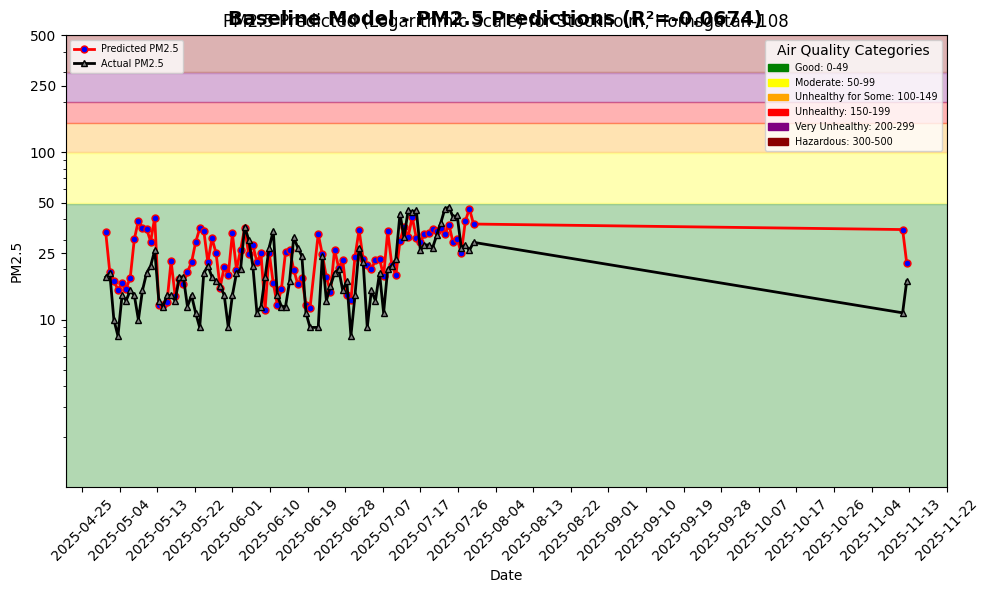

✅ Baseline plot saved: air_quality_model/images/pm25_hindcast_baseline.png

2. Enhanced Model (Weather + Lagged Features):


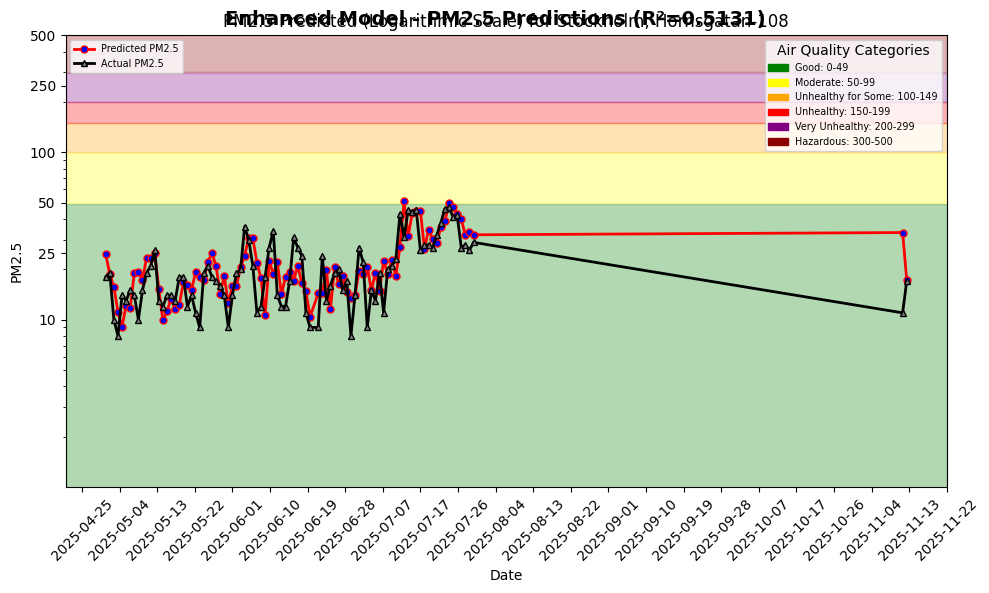

✅ Enhanced plot saved: air_quality_model/images/pm25_hindcast_enhanced.png

📊 Both prediction plots saved to: air_quality_model/images


In [64]:
# Plot PM2.5 predictions for both models
print("\n📊 Plotting PM2.5 predictions...")

# Baseline model plot
print("\n1. Baseline Model (Weather Only):")
file_path_baseline = images_dir + "/pm25_hindcast_baseline.png"
plt_obj_baseline = util.plot_air_quality_forecast(city, street, df_baseline, file_path_baseline, hindcast=True)
plt_obj_baseline.suptitle(f'Baseline Model - PM2.5 Predictions (R²={r2_baseline:.4f})', fontsize=14, fontweight='bold', y=0.98)
plt_obj_baseline.show()
print(f"✅ Baseline plot saved: {file_path_baseline}")

# Enhanced model plot
print("\n2. Enhanced Model (Weather + Lagged Features):")
file_path_enhanced = images_dir + "/pm25_hindcast_enhanced.png"
plt_obj_enhanced = util.plot_air_quality_forecast(city, street, df_enhanced, file_path_enhanced, hindcast=True)
plt_obj_enhanced.suptitle(f'Enhanced Model - PM2.5 Predictions (R²={r2_enhanced:.4f})', fontsize=14, fontweight='bold', y=0.98)
plt_obj_enhanced.show()
print(f"✅ Enhanced plot saved: {file_path_enhanced}")

print(f"\n📊 Both prediction plots saved to: {images_dir}")


📊 Plotting feature importance comparison...
✅ Feature importance comparison plot saved: air_quality_model/images/feature_importance_comparison.png


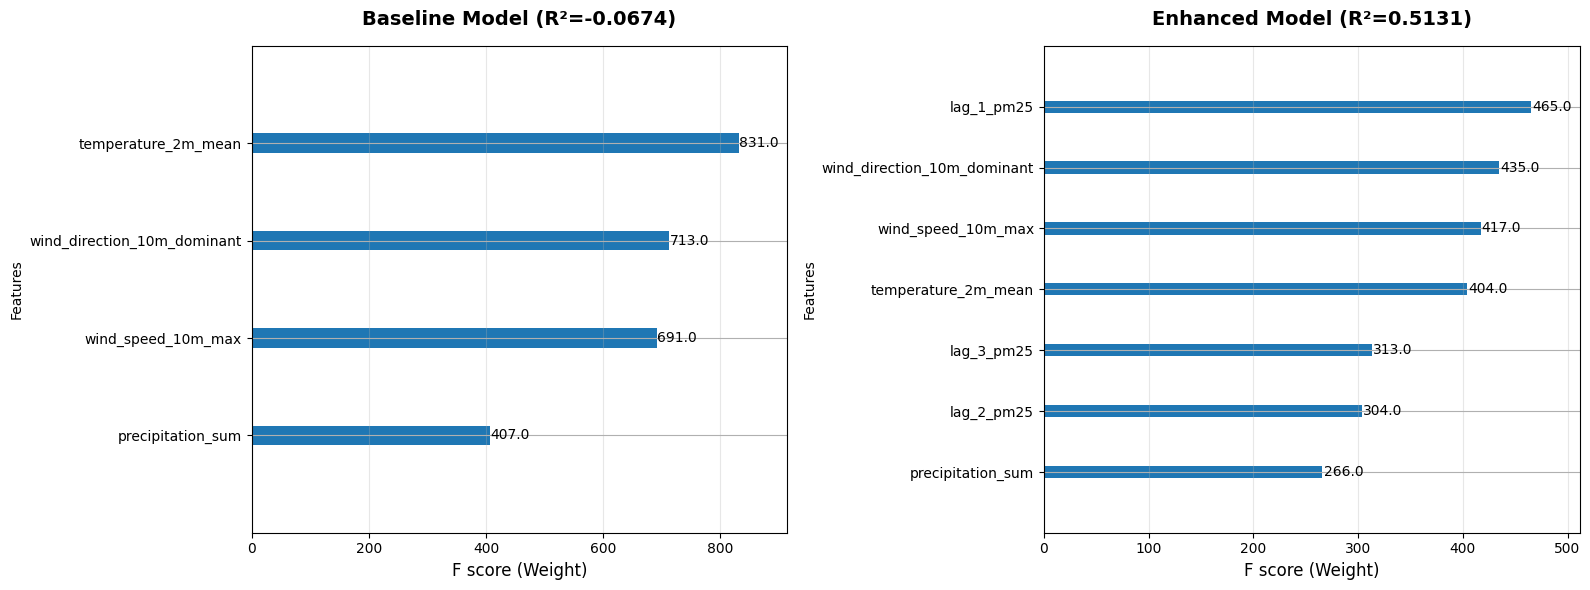

In [65]:
# Plot feature importance comparison using XGBoost built-in function
print("\n📊 Plotting feature importance comparison...")

# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline model feature importance
plt.sca(axes[0])
plot_importance(model_baseline, ax=axes[0], max_num_features=10, 
                importance_type='weight', show_values=True)
axes[0].set_title(f'Baseline Model (R²={r2_baseline:.4f})', 
                 fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('F score (Weight)', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Enhanced model feature importance
plt.sca(axes[1])
plot_importance(model_enhanced, ax=axes[1], max_num_features=10, 
                importance_type='weight', show_values=True)
axes[1].set_title(f'Enhanced Model (R²={r2_enhanced:.4f})', 
                 fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('F score (Weight)', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()

# Save the plot
feature_importance_path = images_dir + "/feature_importance_comparison.png"
plt.savefig(feature_importance_path, dpi=300, bbox_inches='tight')
print(f"✅ Feature importance comparison plot saved: {feature_importance_path}")

plt.show()

---

## <span style='color:#ff5f27'>🗄 Save Models and Upload to Hopsworks</span>

We save both models locally and upload the Enhanced model (best performing) to Hopsworks Model Registry.

In [66]:
# Save both models locally
print("\n💾 Saving models locally...")

# Save Baseline model
baseline_model_dir = "air_quality_model"
os.makedirs(baseline_model_dir, exist_ok=True)
model_baseline.save_model(baseline_model_dir + "/model.json")
print(f"  ✅ Baseline model saved: {baseline_model_dir}/model.json")

# Save Enhanced model
enhanced_model_dir = "air_quality_model_enhanced"
os.makedirs(enhanced_model_dir, exist_ok=True)
model_enhanced.save_model(enhanced_model_dir + "/model.json")
print(f"  ✅ Enhanced model saved: {enhanced_model_dir}/model.json")


💾 Saving models locally...
  ✅ Baseline model saved: air_quality_model/model.json
  ✅ Enhanced model saved: air_quality_model_enhanced/model.json


In [70]:
# Prepare model metrics for both models
# Note: Hopsworks only accepts numeric metrics and requires Python native types (not numpy types)
print("\n📊 Preparing model metrics...")

# Baseline model metrics (convert to Python native types)
res_dict_baseline = { 
    "MSE": float(mse_baseline),
    "RMSE": float(rmse_baseline),
    "MAE": float(mae_baseline),
    "R2": float(r2_baseline),
    "n_features": int(X_train_base_features.shape[1])
}

# Enhanced model metrics (convert to Python native types)
res_dict_enhanced = { 
    "MSE": float(mse_enhanced),
    "RMSE": float(rmse_enhanced),
    "MAE": float(mae_enhanced),
    "R2": float(r2_enhanced),
    "n_features": int(X_train_enh_features.shape[1]),
    "baseline_R2": float(r2_baseline),
    "improvement_percent": float(r2_improve)
}

print(f"  Baseline metrics: MSE={mse_baseline:.2f}, R²={r2_baseline:.4f}")
print(f"  Enhanced metrics: MSE={mse_enhanced:.2f}, R²={r2_enhanced:.4f}, Improvement={r2_improve:+.2f}%")


📊 Preparing model metrics...
  Baseline metrics: MSE=106.34, R²=-0.0674
  Enhanced metrics: MSE=48.50, R²=0.5131, Improvement=+861.27%


In [71]:
# Upload models to Hopsworks Model Registry
print("\n🗄 Uploading models to Hopsworks Model Registry...")
mr = project.get_model_registry()

# 1. Upload Baseline model
print("\n1️⃣ Uploading Baseline model...")
aq_model_baseline = mr.python.create_model(
    name="air_quality_xgboost_model_baseline", 
    metrics=res_dict_baseline,
    feature_view=feature_view_baseline,
    description="Air Quality (PM2.5) predictor - Baseline model using weather features only",
)
aq_model_baseline.save(baseline_model_dir)
print("  ✅ Baseline model uploaded!")
print(f"     Model: air_quality_xgboost_model_baseline")
print(f"     Feature View: air_quality_fv_baseline")
print(f"     R² score: {r2_baseline:.4f}")

# 2. Upload Enhanced model
print("\n2️⃣ Uploading Enhanced model...")
aq_model_enhanced = mr.python.create_model(
    name="air_quality_xgboost_model_enhanced", 
    metrics=res_dict_enhanced,
    feature_view=feature_view_enhanced,
    description="Air Quality (PM2.5) predictor with lagged features - Enhanced model using weather + 1,2,3-day lagged PM2.5",
)
aq_model_enhanced.save(enhanced_model_dir)
print("  ✅ Enhanced model uploaded!")
print(f"     Model: air_quality_xgboost_model_enhanced")
print(f"     Feature View: air_quality_fv_enhanced")
print(f"     R² score: {r2_enhanced:.4f}")
print(f"     Improvement: {r2_improve:+.2f}%")

print(f"\n{'='*80}")
print("🎉 Both models successfully uploaded to Hopsworks Model Registry!")
print(f"{'='*80}")


🗄 Uploading models to Hopsworks Model Registry...

1️⃣ Uploading Baseline model...


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading F:\ID2223\Air_Quality_Prediction\notebooks\airquality\air_quality_model/model.json: 0.000%|         …

Uploading F:\ID2223\Air_Quality_Prediction\notebooks\airquality\air_quality_model\images/feature_importance.pn…

Uploading F:\ID2223\Air_Quality_Prediction\notebooks\airquality\air_quality_model\images/feature_importance_co…

Uploading F:\ID2223\Air_Quality_Prediction\notebooks\airquality\air_quality_model\images/pm25_hindcast.png: 0.…

Uploading F:\ID2223\Air_Quality_Prediction\notebooks\airquality\air_quality_model\images/pm25_hindcast_baselin…

Uploading F:\ID2223\Air_Quality_Prediction\notebooks\airquality\air_quality_model\images/pm25_hindcast_enhance…

Uploading F:\ID2223\Air_Quality_Prediction\notebooks\airquality\model_schema.json: 0.000%|          | 0/605 el…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298582/models/air_quality_xgboost_model_baseline/1
  ✅ Baseline model uploaded!
     Model: air_quality_xgboost_model_baseline
     Feature View: air_quality_fv_baseline
     R² score: -0.0674

2️⃣ Uploading Enhanced model...


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading F:\ID2223\Air_Quality_Prediction\notebooks\airquality\air_quality_model_enhanced/model.json: 0.000%|…

Uploading F:\ID2223\Air_Quality_Prediction\notebooks\airquality\model_schema.json: 0.000%|          | 0/830 el…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298582/models/air_quality_xgboost_model_enhanced/1
  ✅ Enhanced model uploaded!
     Model: air_quality_xgboost_model_enhanced
     Feature View: air_quality_fv_enhanced
     R² score: 0.5131
     Improvement: +861.27%

🎉 Both models successfully uploaded to Hopsworks Model Registry!


---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
